In [1]:
import os
import numpy as np
import scipy.spatial.distance as sd
import matplotlib.pyplot as plt
from tesser import util
import pandas as pd
from tesser import sr
from tesser import tasks
from tesser import util
from tesser import rsa
import importlib
from scipy.spatial import distance
from scipy import stats
import seaborn as sns
#work desktop:
data_dir = '/Users/athula/Dropbox/Experiments/tesser_successor/Data/'
#laptop:
#data_dir = '/Users/athulapudhiyidath/Dropbox/Experiments/tesser_successor/Data'
roi_dir = os.path.join(data_dir, 'item_betas', 'roi')

In [2]:
#read in individual induct fits, which match alpha + gamma + tau values of structure learning SR 
#based on participants' performance in the inductive inference task

induct_fits = pd.read_csv('individual_induct_fits.csv')
induct_fits

,gamma,alpha,tau,subject,log_like
0,1.000000,0.868522,0.406603,100,-28.982943
1,0.992111,0.712546,2.711300,101,-25.406295
2,0.776365,0.022944,0.725350,102,-20.825487
3,0.925354,0.685405,1.307411,103,-25.866600
4,0.009605,0.221198,0.052226,104,-28.795034
5,1.000000,0.129351,2.040548,105,-22.919007
6,0.703446,0.103798,0.894550,106,-24.974311
7,0.992454,0.937988,1.459442,107,-27.662605
8,0.997764,0.600533,0.656194,108,-28.698749
9,0.167990,0.001543,0.466543,109,-19.508192


In [3]:
behavior_dir = '/Users/athula/Dropbox/Experiments/TesserScan/analyses/behavior'
induct_bias = pd.read_csv(behavior_dir+'/'+'Induct_Results_Bias_Overall.txt', sep='\t')
induct_bias_df = pd.DataFrame(induct_bias)

parsing = pd.read_csv(behavior_dir+'/'+'Parse_OverWalks_Results_Overall.txt', sep='\t') 
parsing_df = pd.DataFrame(parsing)

within_across_dist = pd.read_csv(behavior_dir+'/'+'TesserScan_grouping_perf.csv', sep=",")
within_across_dist_df = pd.DataFrame(within_across_dist)

In [4]:
def prim_index(struct_data):
    struct_part_reset = struct_data.reset_index(drop=True)
    boundary_obj = [18, 3, 4, 10, 11, 17]
    bound_list = []
    for t in range(0, len(struct_part_reset)):
        obj_num = struct_part_reset.objnum[t] 
        if obj_num in boundary_obj:
            bound = 1
        else:
            bound = 0
        bound_list.append(bound)
    struct_part_reset.insert(4, "bound_type", bound_list)
    return struct_part_reset

In [5]:
struct_all = util.load_struct_subject(data_dir, 100)
struct_deux = struct_all[struct_all.part == 2]
struct_deux

,SubjNum,run,trial,objnum,file,orientnam,orientnum,resp,respnum,acc,rt,part,seqtype
2,100,1,3,18,object_10.jpg,cor,1.0,c,1.0,1.0,0.847282,2,1.0
3,100,1,4,20,object_16.jpg,cor,1.0,c,1.0,1.0,0.928597,2,1.0
4,100,1,5,3,object_7.jpg,cor,1.0,c,1.0,1.0,0.628938,2,1.0
5,100,1,6,21,object_25.jpg,cor,1.0,c,1.0,1.0,0.808263,2,1.0
6,100,1,7,19,object_4.jpg,cor,1.0,c,1.0,1.0,0.519963,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,100,6,145,10,object_2.jpg,cor,1.0,c,1.0,1.0,0.567551,2,1.0
145,100,6,146,5,object_30.jpg,cor,1.0,c,1.0,1.0,0.599922,2,1.0
146,100,6,147,8,object_24.jpg,cor,1.0,c,1.0,1.0,0.553967,2,1.0
147,100,6,148,10,object_2.jpg,cor,1.0,c,1.0,1.0,0.581383,2,1.0


In [6]:
this = prim_index(struct_deux)
this

,SubjNum,run,trial,objnum,bound_type,file,orientnam,orientnum,resp,respnum,acc,rt,part,seqtype
0,100,1,3,18,1,object_10.jpg,cor,1.0,c,1.0,1.0,0.847282,2,1.0
1,100,1,4,20,0,object_16.jpg,cor,1.0,c,1.0,1.0,0.928597,2,1.0
2,100,1,5,3,1,object_7.jpg,cor,1.0,c,1.0,1.0,0.628938,2,1.0
3,100,1,6,21,0,object_25.jpg,cor,1.0,c,1.0,1.0,0.808263,2,1.0
4,100,1,7,19,0,object_4.jpg,cor,1.0,c,1.0,1.0,0.519963,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,100,6,145,10,1,object_2.jpg,cor,1.0,c,1.0,1.0,0.567551,2,1.0
878,100,6,146,5,0,object_30.jpg,cor,1.0,c,1.0,1.0,0.599922,2,1.0
879,100,6,147,8,0,object_24.jpg,cor,1.0,c,1.0,1.0,0.553967,2,1.0
880,100,6,148,10,1,object_2.jpg,cor,1.0,c,1.0,1.0,0.581383,2,1.0


In [7]:
#b_hip_tail r-values
roi_list = ['r_hip_ant', 'r_hip_tail']
n_state = 21
M = np.zeros((n_state, n_state))

all_corr_data = pd.DataFrame(columns=roi_list)
for r in range(0, len(roi_list)):
    roi = roi_list[r]
    corr_vals = []
    for s in range(0, len(induct_fits)):
        subject = induct_fits.subject[s]
        gamma_val = induct_fits.gamma[s]
        alpha_val = induct_fits.alpha[s]
        struct_all = util.load_struct_subject(data_dir, subject)
        struct_part2 = struct_all[struct_all['part'] == 2]
        envstep = struct_all.objnum.values - 1         
        sr_reps = sr.neural_sr(envstep, gamma_val, alpha_val, M, n_state)
        sr_reps_part2 = sr_reps[struct_all['part'] == 2]
        
        #getting StructLearn Part 2 with index showing where boundary objects (labled 1) in the sequence are
        struct_part2_bound = prim_index(struct_part2)
        
        #leave out only primary trials in SR Part 2:
        sr_reps_part2_prim = sr_reps_part2[struct_part2_bound['bound_type'] == 0]
        #>> ? << sr_reps_part2_prim_struct = sr_reps_part2[[struct_part2_bound['bound_type'] == 0] & [struct_part2_bound['seqtype'] == 1]]
        
        sr_rdm = distance.squareform(distance.pdist(sr_reps_part2_prim, 'correlation'))
        sr_rdm_sym = rsa.make_sym_matrix(sr_rdm)
        
        patterns = rsa.load_betas(data_dir, subject, roi)   
        #leave out only primary trials in Neural Part 2: 
        patterns_prim = patterns[struct_part2_bound['bound_type'] == 0]
        #>> ? << patterns_prim_struct = patterns[[struct_part2_bound['bound_type'] == 0] & [struct_part2_bound['seqtype'] == 1]]
        neural_rdm = distance.squareform(distance.pdist(patterns_prim, 'correlation'))
        neural_rdm_sym = rsa.make_sym_matrix(neural_rdm)

        #take out autocorrelation
        sr_rdm_sym_rem = rsa.exclude_rsa(sr_rdm_sym, 20)
        neural_rem = neural_rem = rsa.exclude_rsa(neural_rdm, 20)
        
        #r_val, p_val = stats.spearmanr(distance.squareform(sr_rdm_sym), distance.squareform(neural_rdm_sym))
        r_val, p_val = stats.spearmanr(distance.squareform(sr_rdm_sym_rem, checks=False), 
                distance.squareform(neural_rem, checks=False), nan_policy="omit")
        corr_vals.append(r_val)
    
    all_corr_data[roi] = corr_vals
all_corr_data.insert(loc=0, column='subject', value=induct_fits.subject)

In [8]:
all_corr_data

,subject,r_hip_ant,r_hip_tail
0,100,0.000973,-0.001037
1,101,0.000433,0.000107
2,102,-0.001334,0.000405
3,103,0.000257,-0.003683
4,104,-0.001590,-0.001197
5,105,-0.000047,-0.002107
6,106,-0.001023,-0.002269
7,107,-0.002594,-0.000387
8,108,0.002017,0.004536
9,109,0.001420,-0.003297


/Users/athula/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


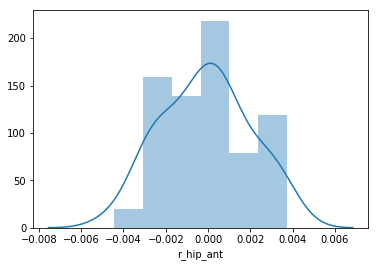

In [9]:
import seaborn as sns
ax = sns.distplot(all_corr_data.r_hip_ant)

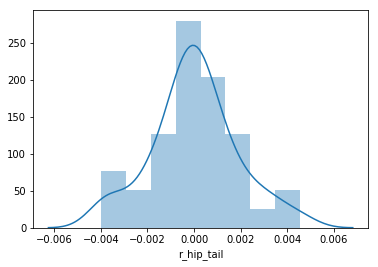

In [10]:
ax = sns.distplot(all_corr_data.r_hip_tail)

In [11]:
np.mean(all_corr_data.r_hip_ant)

-0.00011243645685219525

In [12]:
np.mean(all_corr_data.r_hip_tail)

1.2301968040164392e-05

In [13]:
stats.ttest_rel(all_corr_data.r_hip_ant, all_corr_data.r_hip_tail)

Ttest_relResult(statistic=-0.3420493435338363, pvalue=0.734302636350687)

In [14]:
#index by high performers to examine their correlations:
all_induct_perf = tasks.induct_avg_all(data_dir)
high_perf = tasks.induct_avg_split_high(all_induct_perf)
high_perf

,participant,overall,prim,bound1,bound2
0,102,0.833333,0.866667,0.833333,0.666667
1,103,0.595238,0.600000,0.500000,0.666667
2,105,0.738095,0.666667,0.833333,1.000000
3,106,0.714286,0.733333,0.333333,1.000000
4,109,0.785714,0.833333,0.833333,0.500000
5,111,0.595238,0.633333,0.333333,0.666667
6,113,0.642857,0.633333,0.666667,0.666667
7,119,0.690476,0.666667,0.500000,1.000000
8,121,0.714286,0.700000,0.500000,1.000000
9,122,0.738095,0.700000,0.833333,0.833333


In [15]:
high_corr_data = all_corr_data.loc[all_corr_data.subject.isin(high_perf.participant)]
high_corr_data

,subject,r_hip_ant,r_hip_tail
2,102,-0.001334,0.000405
3,103,0.000257,-0.003683
5,105,-0.000047,-0.002107
6,106,-0.001023,-0.002269
9,109,0.001420,-0.003297
11,111,-0.000040,-0.000611
13,113,-0.000806,0.000580
18,119,0.001224,-0.000144
20,121,-0.002720,0.001047
21,122,-0.002200,-0.003972


/Users/athula/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


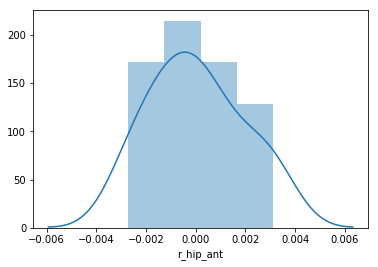

In [16]:
ax = sns.distplot(high_corr_data.r_hip_ant)

In [17]:
np.mean(high_corr_data.r_hip_ant)

2.666625832153241e-05

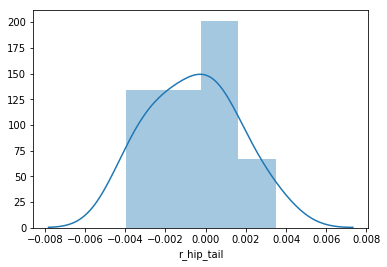

In [18]:
ax = sns.distplot(high_corr_data.r_hip_tail)

In [19]:
np.mean(high_corr_data.r_hip_tail)

-0.000627766148804873

In [20]:
stats.ttest_rel(high_corr_data.r_hip_ant, high_corr_data.r_hip_tail)

Ttest_relResult(statistic=1.1072168396487903, pvalue=0.28564034722418363)

/Users/athula/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


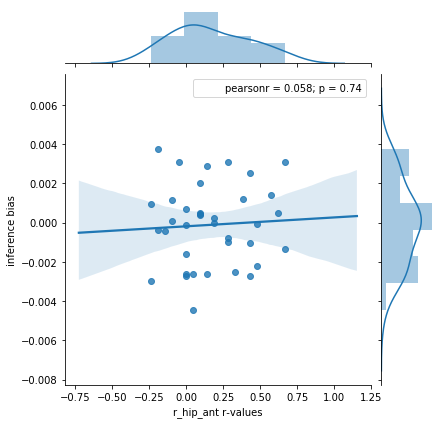

In [21]:
i = sns.jointplot(induct_bias_df['Overall_Bias'], all_corr_data['r_hip_ant'], kind='reg');
i = i.annotate(stats.pearsonr)
plt.ylabel('inference bias')
plt.xlabel('r_hip_ant r-values')
plt.show()
#i.savefig('TesserScan_parse_overallbias.png', dpi = 300)

/Users/athula/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


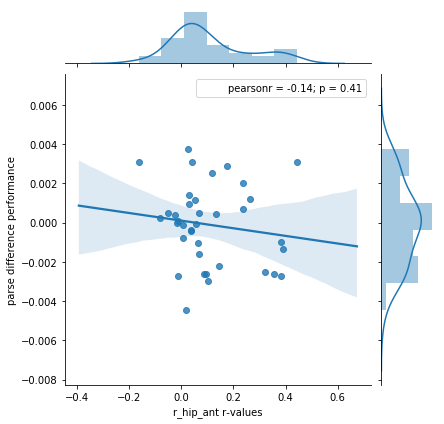

In [22]:
i = sns.jointplot(parsing_df['Parse_Diff'], all_corr_data['r_hip_ant'], kind='reg');
i = i.annotate(stats.pearsonr)
plt.ylabel('parse difference performance')
plt.xlabel('r_hip_ant r-values')
plt.show()
#i.savefig('TesserScan_parse_overallbias.png', dpi = 300)

/Users/athula/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


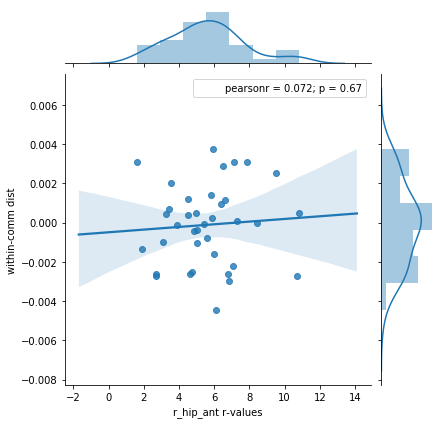

In [23]:
i = sns.jointplot(within_across_dist_df['within_dist'], all_corr_data['r_hip_ant'], kind='reg');
i = i.annotate(stats.pearsonr)
plt.ylabel('within-comm dist')
plt.xlabel('r_hip_ant r-values')
plt.show()
#i.savefig('TesserScan_parse_overallbias.png', dpi = 300)

In [24]:
subject = 101
roi = 'b_hip_ant'
struct_all = util.load_struct_subject(data_dir, subject)
struct_pt1 = struct_all[struct_all.part==1]
struct_pt2 = struct_all[struct_all.part==2]

(2457, 21)

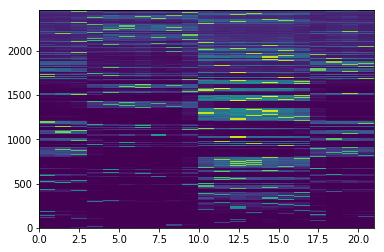

In [25]:
#use all of structure learning, both Part 1 and Part 2 to model SR
envstep = struct_all.objnum.values - 1
n_state = 21
M = np.zeros((n_state, n_state))
sr_reps = sr.neural_sr(envstep, .9, .1, M, n_state)
plt.pcolor(sr_reps)
sr_reps.shape

(1575, 21)

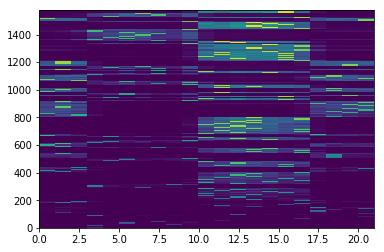

In [26]:
#now only extrat Part 1
sr_reps_part1 = sr_reps[struct_all['part'] == 1]
plt.pcolor(sr_reps_part1)
sr_reps_part1.shape

(882, 21)

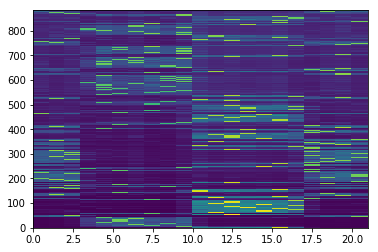

In [27]:
#now only extrat Part 2
sr_reps_part2 = sr_reps[struct_all['part'] == 2]
plt.pcolor(sr_reps_part2)
sr_reps_part2.shape

(882, 859)

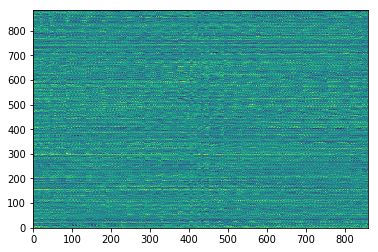

In [28]:
#import the neural data
patterns = rsa.load_betas(data_dir, subject, roi)
plt.pcolor(patterns)
patterns.shape

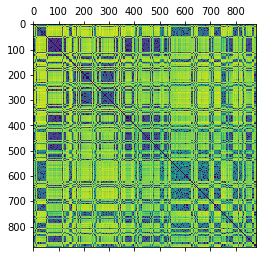

In [29]:
sr_rdm = distance.squareform(distance.pdist(sr_reps_part2, 'correlation'))
#make SR matrix symmetric:
sr_rdm_sym = rsa.make_sym_matrix(sr_rdm)
plt.matshow(sr_rdm)

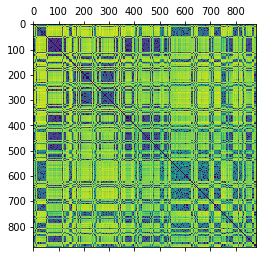

In [30]:
plt.matshow(sr_rdm_sym)

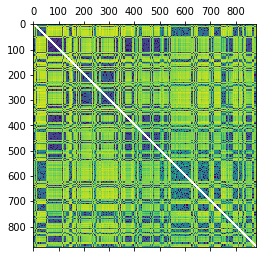

In [31]:
sr_rem = rsa.exclude_rsa(sr_rdm_sym, 5)
plt.matshow(sr_rem)

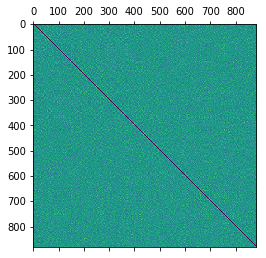

In [32]:
neural_rdm = distance.squareform(distance.pdist(patterns, 'correlation'))
#make neural matrix symmetric:
plt.matshow(neural_rdm)

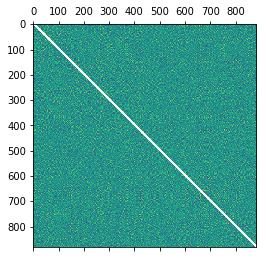

In [33]:
neural_rem = rsa.exclude_rsa(neural_rdm, 5)
plt.matshow(neural_rem)

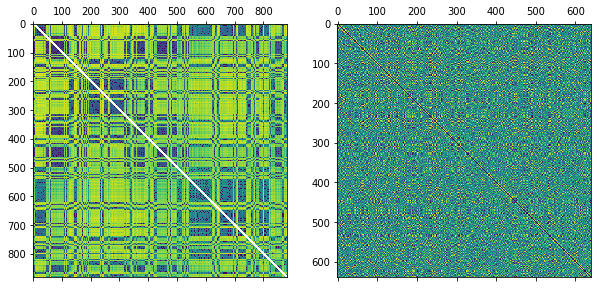

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].matshow(sr_rdm_sym)
vmin, vmax = np.percentile(distance.squareform(neural_rdm_sym), [1, 99])
ax[1].matshow(neural_rdm_sym, vmin=vmin, vmax=vmax)

In [35]:
stats.spearmanr(distance.squareform(sr_rem, checks=False), 
                distance.squareform(neural_rem, checks=False), nan_policy="omit")

SpearmanrResult(correlation=-0.0022860677660538897, pvalue=masked_array(data=0.15605344,
             mask=False,
       fill_value=1e+20))

In [36]:
help(stats.spearmanr)

Help on function spearmanr in module scipy.stats.stats:

spearmanr(a, b=None, axis=0, nan_policy='propagate')
    Calculate a Spearman rank-order correlation coefficient and the p-value
    to test for non-correlation.
    
    The Spearman correlation is a nonparametric measure of the monotonicity
    of the relationship between two datasets. Unlike the Pearson correlation,
    the Spearman correlation does not assume that both datasets are normally
    distributed. Like other correlation coefficients, this one varies
    between -1 and +1 with 0 implying no correlation. Correlations of -1 or
    +1 imply an exact monotonic relationship. Positive correlations imply that
    as x increases, so does y. Negative correlations imply that as x
    increases, y decreases.
    
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Spearman correlation at least as extreme
    as the one computed from these datasets. The p-values are not 